
# Predição de Doenças Cardíacas com Machine Learning

Este notebook tem como objetivo desenvolver um modelo de machine learning capaz de prever a predisposição de uma pessoa a doenças cardíacas. O modelo será posteriormente integrado a uma aplicação real, composta por um frontend em React e um backend em Python, que fará uso do modelo treinado para realizar predições com base nos dados fornecidos pelos usuários.

Este projeto faz parte da disciplina de **Qualidade de Software, Segurança e Sistemas Inteligentes**, do curso de **Engenharia de Software**, e foi desenvolvido pelo aluno **Saulo Lins Dias**.

## Sobre o Dataset

Os dados utilizados neste projeto foram obtidos no [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data), mais especificamente do conjunto de dados **Heart Failure Prediction**. O objetivo do dataset é auxiliar na identificação precoce do risco de falha cardíaca com base em características clínicas e comportamentais.

O dataset contém 918 registros e 12 colunas, sendo que a variável-alvo é `HeartDisease`, indicando se o paciente possui (1) ou não (0) uma doença cardíaca. As colunas presentes no dataset são:

* `Age`: Idade do paciente.
* `Sex`: Sexo biológico do paciente (F = feminino, M = masculino).
* `ChestPainType`: Tipo de dor no peito (valores categóricos como TA, ATA, NAP, ASY).
* `RestingBP`: Pressão arterial em repouso (em mm Hg).
* `Cholesterol`: Nível de colesterol sérico (em mg/dl).
* `FastingBS`: Glicemia de jejum (1 = maior que 120 mg/dl, 0 = menor ou igual).
* `RestingECG`: Resultados do eletrocardiograma em repouso (valores categóricos).
* `MaxHR`: Frequência cardíaca máxima alcançada.
* `ExerciseAngina`: Angina induzida por exercício (Y = sim, N = não).
* `Oldpeak`: Depressão do segmento ST induzida por exercício em relação ao repouso.
* `ST_Slope`: Inclinação do segmento ST no pico do exercício (valores categóricos).
* `HeartDisease`: Variável alvo indicando presença (1) ou ausência (0) de doença cardíaca.



## 1. Configuração do Ambiente

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

import joblib


## 2. Carregamento dos Dados

In [2]:
import kagglehub

from pathlib import Path

# Faz o download da última versão do dataset
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
path = Path(path)

df = pd.read_csv(path/"heart.csv", delimiter=',')
df.head()


C:\Users\saulo\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 3. Tratamento dos Dados

In [3]:

# Verificando valores nulos
print(df.isnull().sum())

# Criando coluna target para estudo
df['target'] = df['HeartDisease']
df.drop(columns=['HeartDisease'], inplace=True)

# Tratar colunas categóricas
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_cols = [col for col in df.columns if col not in cat_cols + ['target']]

df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})
df['ST_Slope'] = df['ST_Slope'].map({'Up': 0, 'Flat': 1, 'Down': 2})
df['RestingECG'] = df['RestingECG'].map({'Normal': 0, 'ST': 1, 'LVH': 2})
df['ChestPainType'] = df['ChestPainType'].map({'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3})

# Verificando os tipos de dados e estatísticas básicas
df.info()
df.head()


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  target          918 non-null    int64  
dtypes: floa

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,target
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,0,130,283,0,1,98,0,0.0,0,0
3,48,1,2,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,0,0


## 4. Separação dos Conjuntos de Treino e Teste (Validação Cruzada Estratificada)

In [4]:

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## 5. Avaliação de Modelos com Dados Brutos

In [5]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "CART": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Voting": VotingClassifier(
        estimators=[
          ('svm', SVC(probability=True)),
          ('lr', LogisticRegression(max_iter=1000)),
          ('rf', RandomForestClassifier())
        ],
        voting='soft'
    )
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Logistic Regression: 0.8515 ± 0.0376
Decision Tree: 0.7929 ± 0.0315
CART: 0.7929 ± 0.0307
Naive Bayes: 0.8406 ± 0.0411
Random Forest: 0.8515 ± 0.0286
SVM: 0.7166 ± 0.0324
KNN: 0.6894 ± 0.0346
AdaBoost: 0.8624 ± 0.0313
Voting: 0.8556 ± 0.0336


## 6. Comparação com Dados Normalizados e Padronizados

In [6]:

# Padronização
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X_train)

# Normalização
scaler_minmax = MinMaxScaler()
X_norm = scaler_minmax.fit_transform(X_train)

# Testando com dados padronizados
print("### Dados Padronizados")
for name, model in models.items():
    scores = cross_val_score(model, X_std, y_train, cv=skf, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Testando com dados normalizados
print("\n### Dados Normalizados")
for name, model in models.items():
    scores = cross_val_score(model, X_norm, y_train, cv=skf, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


### Dados Padronizados
Logistic Regression: 0.8488 ± 0.0409
Decision Tree: 0.7765 ± 0.0306
CART: 0.7806 ± 0.0192
Naive Bayes: 0.8406 ± 0.0411
Random Forest: 0.8379 ± 0.0367
SVM: 0.8570 ± 0.0441
KNN: 0.8542 ± 0.0373
AdaBoost: 0.8624 ± 0.0313
Voting: 0.8638 ± 0.0313

### Dados Normalizados
Logistic Regression: 0.8556 ± 0.0398
Decision Tree: 0.7929 ± 0.0255
CART: 0.7861 ± 0.0273
Naive Bayes: 0.8406 ± 0.0411
Random Forest: 0.8434 ± 0.0257
SVM: 0.8638 ± 0.0330
KNN: 0.8502 ± 0.0288
AdaBoost: 0.8624 ± 0.0313
Voting: 0.8638 ± 0.0333


## 7. Comparação Gráfica dos Modelos

[Bruto]Logistic Regression: 0.8515 ± 0.0376
[Bruto]Decision Tree: 0.7847 ± 0.0263
[Bruto]CART: 0.7875 ± 0.0258
[Bruto]Naive Bayes: 0.8406 ± 0.0411
[Bruto]Random Forest: 0.8420 ± 0.0415
[Bruto]SVM: 0.7166 ± 0.0324
[Bruto]KNN: 0.6894 ± 0.0346
[Bruto]AdaBoost: 0.8624 ± 0.0313
[Bruto]Voting: 0.8501 ± 0.0295
[Padronizado]Logistic Regression: 0.8488 ± 0.0409
[Padronizado]Decision Tree: 0.7902 ± 0.0278
[Padronizado]CART: 0.7847 ± 0.0251
[Padronizado]Naive Bayes: 0.8406 ± 0.0411
[Padronizado]Random Forest: 0.8556 ± 0.0286
[Padronizado]SVM: 0.8570 ± 0.0441
[Padronizado]KNN: 0.8542 ± 0.0373
[Padronizado]AdaBoost: 0.8624 ± 0.0313
[Padronizado]Voting: 0.8638 ± 0.0281
[Normalizado]Logistic Regression: 0.8556 ± 0.0398
[Normalizado]Decision Tree: 0.7915 ± 0.0250
[Normalizado]CART: 0.7861 ± 0.0265
[Normalizado]Naive Bayes: 0.8406 ± 0.0411
[Normalizado]Random Forest: 0.8488 ± 0.0408
[Normalizado]SVM: 0.8638 ± 0.0330
[Normalizado]KNN: 0.8502 ± 0.0288
[Normalizado]AdaBoost: 0.8624 ± 0.0313
[Normalizado]V

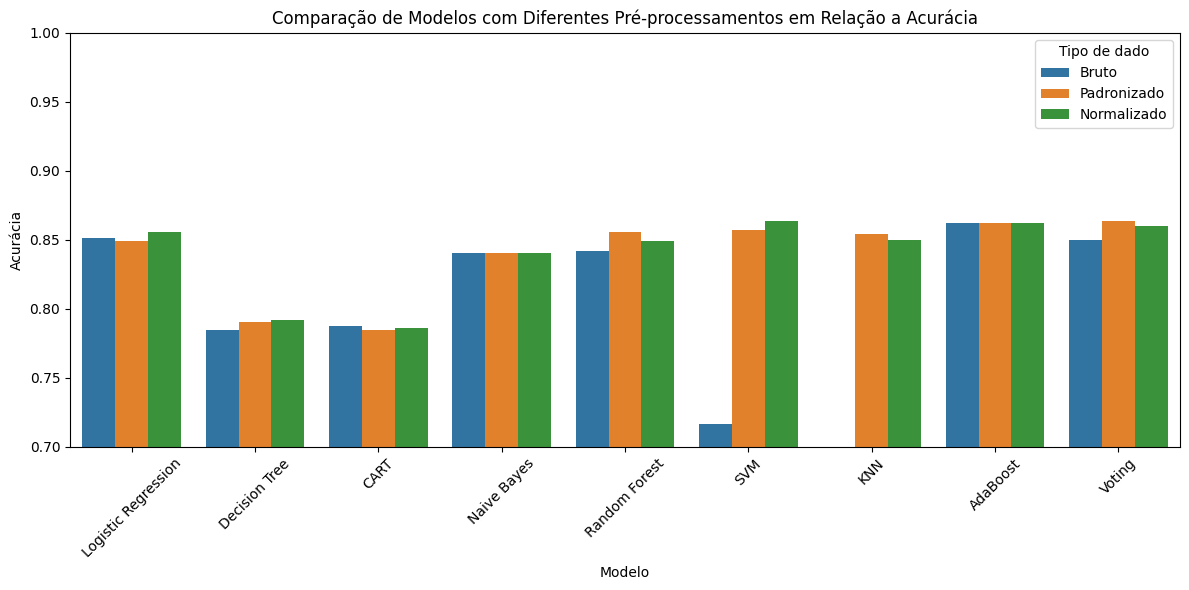

In [7]:

import matplotlib.pyplot as plt

# Avaliação e comparação dos modelos
def evaluate_models(X_versions, version_names):
    results = {}

    for Xv, name in zip(X_versions, version_names):
        for model_name, model in models.items():
            scores = cross_val_score(model, Xv, y_train, cv=skf, scoring='accuracy')
            results[(model_name, name)] = np.mean(scores)
            print(f"[{name}]{model_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return results

# Avaliando modelos com as três versões de dados
X_versions = [X_train, X_std, X_norm]
version_names = ['Bruto', 'Padronizado', 'Normalizado']

results = evaluate_models(X_versions, version_names)

# Preparando dados para gráfico
import pandas as pd

df_results = pd.DataFrame([
    {'Modelo': model, 'Versão': version, 'Acurácia': acc}
    for (model, version), acc in results.items()
])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='Modelo', y='Acurácia', hue='Versão')
plt.title('Comparação de Modelos com Diferentes Pré-processamentos em Relação a Acurácia')
plt.ylim(0.7, 1.0)
plt.legend(title='Tipo de dado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 8. Otimização de Hiperparâmetros para os Melhores Modelos

Nesta etapa, utilizaremos o GridSearchCV para otimizar os hiperparâmetros dos modelos que tiveram melhor desempenho anteriormente: **Random Forest**, **SVM** e **Voting Classifier**. O objetivo é maximizar a acurácia mantendo a estabilidade.

In [8]:
from sklearn.model_selection import GridSearchCV

# Pipeline para SVM com normalização
pipe_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(probability=True))
])
param_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear']
}
grid_svm = GridSearchCV(pipe_svm, param_svm, cv=skf, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_norm, y_train)

# AdaBoost (com dados brutos)
param_ada = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0, 1.5]
}
grid_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_ada, cv=skf, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train, y_train)

# Random Forest para VotingClassifier
param_rf = {
    'n_estimators': [100],
    'max_depth': [None, 5],
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=skf, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_std, y_train)

# Voting com os melhores estimadores (com padronização)
best_ada = grid_ada.best_estimator_
best_rf = grid_rf.best_estimator_

voting = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('ada', best_ada)
], voting='soft')

scores_voting = cross_val_score(voting, X_std, y_train, cv=skf, scoring='accuracy')

# Resultados
print("Melhor SVM:", grid_svm.best_params_, f"Acurácia: {grid_svm.best_score_:.4f}")
print("Melhor AdaBoost:", grid_ada.best_params_, f"Acurácia: {grid_ada.best_score_:.4f}")
print("Melhor Random Forest:", grid_rf.best_params_, f"Acurácia: {grid_rf.best_score_:.4f}")
print("Voting (RF + ADA) Acurácia média:", scores_voting.mean(), "±", scores_voting.std())

Melhor SVM: {'svm__C': 1, 'svm__kernel': 'rbf'} Acurácia: 0.8638
Melhor AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50} Acurácia: 0.8624
Melhor Random Forest: {'max_depth': 5, 'n_estimators': 100} Acurácia: 0.8610
Voting (RF + ADA) Acurácia média: 0.8651477029167831 ± 0.04106035796975315


## 9. Exportação do Modelo Final

In [ ]:

# Criação do modelo final com VotingClassifier
voting.fit(X_train, y_train)
predictions = voting.predict(X_test)

# Avaliação do modelo final
print("Acurácia do modelo final:", accuracy_score(y_test, predictions))

# Salvando modelo e scaler
joblib.dump(voting, 'model.pkl')

Acurácia do modelo final: 0.8967391304347826


['model.pkl']